<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using pycaret</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [github:pycaret](https://github.com/pycaret)
- [TWS: PyCaret 2.2 is here — What’s new?](https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b)
- [pycaret-demo-queens/PyCaret 2 Classification.ipynb](https://github.com/pycaret/pycaret-demo-queens/blob/main/PyCaret%202%20Classification.ipynb)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO for pycaret
    !pip install tune-sklearn
    !pip install optuna # hyperopt is already in colab

    # gpu version of lightgbm for pycaret
    !pip uninstall lightgbm -y
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    # regular pycaret without gpu 
    !pip install pycaret-nightly[full]

    # ipywidget
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    print('Environment: Google Colab')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret

%load_ext watermark
%watermark -iv

pycaret   : 2.2.2
json      : 2.0.9
sys       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
pandas    : 1.1.5
numpy     : 1.19.4
autopep8  : 1.5.4
seaborn   : 0.11.0
joblib    : 1.0.0
matplotlib: 3.2.2



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [4]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [5]:
def compare_new_models(name,desc,mean_row,ofile,
                       df_eval=None,sort='Recall',show=True):
    """Create dataframe from output of pycaret new model.
    Parameters
    -----------
    name: str
        Name of the model. eg. xgboost
    desc: str
        Description of the model. e.g tuned,calibrated
    mean_arr: np.ndarray
        The mean row.
        e.g. 
        df_res = pyc.pull()
        mean_row = df_res.loc['Mean']
    ofile: str
        Output file name. e.g. 'pycaret_df_eval_lr.csv'
    df_eval: Pandas Dataframe
        Template pandas dataframe
    sort: str
       One of following string: Accuracy, AUC, Recall, Precision, F1, Kappa

    Returns:
       Pandas Dataframe.
    """
    
    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'Accuracy':[],
                                'AUC':[],
                                'Recall':[],
                                'Precision':[],
                                'F1':[],
                                'Kappa':[],
                                'MCC': [],
                                'LogLoss': []
                               })

    acc,auc,rec,pre,f1,kap,mcc,logloss = mean_row
    row = [name,desc,acc,auc,rec,pre,f1,kap,mcc,logloss]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates()\
                     .sort_values(sort,ascending=False)
    df_eval.index = range(len(df_eval))
    
    df_style = (df_eval.style.apply(lambda ser:
                ['background: tomato'
                 if ser.name == sort else ''
                 for _ in ser]))

    if show:
        display(df_style)

    # save the data
    df_eval.to_csv(ofile)
    
    return df_eval

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [6]:
path_data_train = '../data/processed/train_cleaned.csv'
path_data_test = '../data/processed/test_cleaned.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/train_cleaned.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/test_cleaned.csv'

In [7]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 39)
(1409, 39)


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,NoSeniorCitizen_Contract_Month-to-month,PaymentMethod0_Contract_Month-to-month0,InternetService_Fiber optic,StreamingTV_NoInternetService,No_OB_DP_TS,TotalServices,SenCit_Dependents,Partner_Dependents,SenCit_Partner,SenCit_Contract,SenCit_TechSupport,SenCit_PayMeth,Contract_mean_totCharges,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat
0,0,0,1,0,36,1,2,1,2,2,2,2,0,2,2,1,1,106.05,3834.40,0,1,0,0,0,1,1,2,0,1,1,2,2,1,3683.643192,150.756808,66.703657,39.346343,3,0
1,1,0,0,0,10,1,0,0,2,0,0,2,2,0,0,0,1,62.25,612.95,0,0,1,0,1,1,1,1,0,0,0,0,2,1,1370.923131,-757.973131,66.703657,-4.453657,0,0
5632,0,0,1,1,68,1,2,1,0,2,0,2,2,2,2,1,1,103.75,7039.45,0,1,0,0,0,1,1,2,1,2,1,2,2,1,3683.643192,3355.806808,66.703657,37.046343,5,0
5633,1,0,0,0,69,1,2,2,1,1,1,1,1,1,2,0,1,23.95,1713.10,0,1,0,0,1,0,1,7,0,0,0,2,1,1,3683.643192,-1970.543192,66.703657,-42.753657,5,0


In [8]:
path_data_test_raw = ('https://raw.githubusercontent.com/'
                      'bhishanpdl/Datasets/master/Projects/'
                      'Telco_Customer_Churn/raw/test.csv')
                      
df_test_raw1 = pd.read_csv(path_data_test_raw,usecols=['customerID'])
df_test_raw1.head(2)

,customerID
0,1794-HBQTJ
1,0356-OBMAC


In [9]:
ser_test_ids = df_test_raw1['customerID']
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [10]:
# check for nans
df_train.isna().sum().sum()

0

<a id="" ></a>

<h1>  Modelling Pycaret </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [11]:
import pycaret
import pycaret.classification as pyc

<a id="" ></a>

<h1>  Pycaret Setup</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.setup(
    data: pandas.core.frame.DataFrame,
    target: str,
    train_size                    = 0.7,
    test_data                     = None,
    preprocess                    = True,
    imputation_type               = 'simple',
    iterative_imputation_iters    = 5,
    categorical_features          = None,
    categorical_imputation        = 'constant',
    categorical_iterative_imputer = 'lightgbm',
    ordinal_features              = None,
    high_cardinality_features     = None,
    high_cardinality_method       = 'frequency',
    numeric_features              = None,
    numeric_imputation            = 'mean',
    numeric_iterative_imputer     = 'lightgbm',
    date_features                 = None,
    ignore_features               = None,
    normalize                     = False,
    normalize_method              = 'zscore',
    transformation                = False,
    transformation_method         = 'yeo-johnson',
    handle_unknown_categorical    = True,
    unknown_categorical_method    = 'least_frequent',
    pca                           = False,
    pca_method                    = 'linear',
    pca_components                = None,
    ignore_low_variance           = False,
    combine_rare_levels           = False,
    rare_level_threshold          = 0.1,
    bin_numeric_features          = None,
    remove_outliers               = False,
    outliers_threshold            = 0.05,
    remove_multicollinearity      = False,
    multicollinearity_threshold   = 0.9,
    remove_perfect_collinearity   = True,
    create_clusters               = False,
    cluster_iter                  = 20,
    polynomial_features           = False,
    polynomial_degree             = 2,
    trigonometry_features         = False,
    polynomial_threshold          = 0.1,
    group_features                = None,
    group_names                   = None,
    feature_selection             = False,
    feature_selection_threshold   = 0.8,
    feature_selection_method      = 'classic',
    feature_interaction           = False,
    feature_ratio                 = False,
    interaction_threshold         = 0.01,
    fix_imbalance                 = False,
    fix_imbalance_method          = None,
    data_split_shuffle            = True,
    data_split_stratify           = False,
    fold_strategy                 = 'stratifiedkfold',
    fold                          = 10,
    fold_shuffle                  = False,
    fold_groups                   = None,
    n_jobs                        = -1,
    use_gpu                       = False,
    custom_pipeline               = None,
    html                          = True,
    session_id                    = None,
    log_experiment                = False,
    experiment_name               = None,
    log_plots                     = False,
    log_profile                   = False,
    log_data                      = False,
    silent                        = False,
    verbose                       = True,
    profile                       = False,
    profile_kwargs                = None,
)

```

In [12]:
df_train.shape

(5634, 39)

In [13]:
show_methods(pyc)

,0,1,2,3
0,Any,calibrate_model,interpret_model,pull
1,Dict,compare_models,io,pycaret
2,Display,create_model,is_in_colab,remove_metric
3,List,deploy_model,load_config,save_config
4,MLUsecase,enable_colab,load_model,save_model
5,Optional,ensemble_model,models,set_config
6,Tuple,evaluate_model,np,setup
7,Union,finalize_model,optimize_threshold,stack_models
8,add_metric,get_config,pd,traceback
9,automl,get_logs,plot_model,tune_model


In [14]:
USE_GPU = False
if ENV_COLAB:
    USE_GPU = True

In [15]:
exp = pyc.setup(df_train,target_name,
                train_size=0.8,
                session_id=SEED,
                use_gpu=USE_GPU,
                preprocess = True,
                categorical_features = None,
                ordinal_features = None,
                high_cardinality_features = None,
                numeric_features = None,
                date_features = None,
                ignore_features = None,
                normalize = False,
                data_split_stratify = True,
                silent=True,
                profile=False,
                log_experiment=False
                )

# use silent = True to check inferred datatypes
# then assign numeric and categorical features yourself.
#
# if sampling = False, 100% of data is used and its too slow
# if sampling = True, we need to enter number eg. 0.3 ourself.

"""
Here, we have data < 25k rows, so I have chosen not to use sampling.

""";

,Description,Value
0,session_id,100
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5634, 39)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
pyc.models(internal=True)[['Name', 'GPU Enabled']]

# google colab does not support cuml and thereby sklearn models
# we need to run blazingsql notebooks (not colab) to use cuml models.

,Name,GPU Enabled
ID,,
lr,Logistic Regression,False
knn,K Neighbors Classifier,False
nb,Naive Bayes,False
dt,Decision Tree Classifier,False
svm,SVM - Linear Kernel,False
rbfsvm,SVM - Radial Kernel,False
gpc,Gaussian Process Classifier,False
mlp,MLP Classifier,False
ridge,Ridge Classifier,False


<a id="" ></a>

<h1>  Comparing Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>



Comparing All Models
- compare using stratified cross validation for metric evaluation.
- shows average metrics for score grid for 10 fold cross-validation
- default sorting is `accuracy`


```python
pyc.compare_models(
    include          = None,
    exclude          = None,
    fold             = None,
    round            = 4,
    cross_validation = True,
    sort             = 'Accuracy',
    n_select         = 1,
    budget_time      = None,
    turbo            = True,
    errors           = 'ignore',
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
) 
```


In [17]:
# pyc.compare_models?

In [18]:
pyc.get_metrics().index

Index(['acc', 'auc', 'recall', 'precision', 'f1', 'kappa', 'mcc'], dtype='object', name='ID')

In [19]:
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
pyc.add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

Name                                                        LogLoss
Display Name                                                LogLoss
Score Function                <function log_loss at 0x7fc4fe646790>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

<a id="" ></a>

<h1>  Create Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Estimator                   Abbreviated String     Original Implementation 
---------                   ------------------     -------------------------------
Logistic Regression         'lr'                   linear_model.LogisticRegression
K Nearest Neighbour         'knn'                  neighbors.KNeighborsClassifier
Naives Bayes                'nb'                   naive_bayes.GaussianNB
Decision Tree               'dt'                   tree.DecisionTreeClassifier
SVM (Linear)                'svm'                  linear_model.SGDClassifier
SVM (RBF)                   'rbfsvm'               svm.SVC
Gaussian Process            'gpc'                  gaussian_process.GPC
Multi Level Perceptron      'mlp'                  neural_network.MLPClassifier
Ridge Classifier            'ridge'                linear_model.RidgeClassifier
Random Forest               'rf'                   ensemble.RandomForestClassifier
Quadratic Disc. Analysis    'qda'                  discriminant_analysis.QDA
AdaBoost                    'ada'                  ensemble.AdaBoostClassifier
Gradient Boosting           'gbc'                  ensemble.GradientBoostingClassifier
Linear Disc. Analysis       'lda'                  discriminant_analysis.LDA
Extra Trees Classifier      'et'                   ensemble.ExtraTreesClassifier
Extreme Gradient Boosting   'xgboost'              xgboost.readthedocs.io
Light Gradient Boosting     'lightgbm'             github.com/microsoft/LightGBM
CatBoost Classifier         'catboost'             https://catboost.ai
```

```python
pyc.create_model(
    estimator,
    fold             = None,
    round            = 4,
    cross_validation = True,
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
    **kwargs,
)
```

In [20]:
model_name = 'nb'
path_df_eval = 'pycaret_df_eval_nb.csv'
model = pyc.create_model(model_name,verbose=False)

mean_row = pyc.pull().loc['Mean'].values
df_eval = compare_new_models(model_name,'default',mean_row,
                             path_df_eval,sort='Recall',df_eval=None)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.706000,0.824100,0.833600,0.471200,0.601600,0.396700,0.437300,10.154100


<a id="" ></a>

<h1>  Hyperparameter Tuning</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.tune_model(
    estimator,
    fold                     = None,
    round                    = 4,
    n_iter                   = 10,
    custom_grid              = None,
    optimize                 = 'Accuracy',
    custom_scorer            = None,
    search_library           = 'scikit-learn', # 'scikit-optimize', 'tune-sklearn','optuna'
    search_algorithm         = None, # 'scikit-learn', 'scikit-optimize', 'tune-sklearn', 'optuna'
    early_stopping           = False, # 'asha','hyperband','median' 
    early_stopping_max_iters = 10,
    choose_better            = False,
    fit_kwargs               = None,
    groups                   = None,
    return_tuner             = False,
    verbose                  = True,
    tuner_verbose            = True,
    **kwargs,
)
```

In [21]:
# naive bayes takes small time, we may not comment this!

model_tuned1 = pyc.tune_model(model,n_iter=100,search_library='tune-sklearn',
                              fold=5,optimize='Recall',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,tune-sklearn,n_iter=100'
df_eval = compare_new_models(model_name,desc,
                mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,"tuned,tune-sklearn,n_iter=100",0.710200,0.825400,0.837000,0.475600,0.606200,0.404000,0.444400,10.008400
1,nb,default,0.706000,0.824100,0.833600,0.471200,0.601600,0.396700,0.437300,10.154100


In [22]:
# naive bayes takes small time, we may not comment this!

model_tuned2 = pyc.tune_model(model,n_iter=500,search_library='optuna',
                              fold=5,optimize='Recall',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,optuna,n_iter=500'
df_eval = compare_new_models(model_name,desc,
        mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,"tuned,optuna,n_iter=500",0.705800,0.824300,0.839500,0.471200,0.603200,0.398200,0.440200,10.161600
1,nb,"tuned,tune-sklearn,n_iter=100",0.710200,0.825400,0.837000,0.475600,0.606200,0.404000,0.444400,10.008400
2,nb,default,0.706000,0.824100,0.833600,0.471200,0.601600,0.396700,0.437300,10.154100


In [23]:
# naive bayes takes small time, we may not comment this!

model_tuned_F1 = pyc.tune_model(model,n_iter=500,
                                search_library='optuna',
                               fold=5,optimize='F1',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,optuna,n_iter=500,optimize=F1'
df_eval = compare_new_models(model_name,desc,
            mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,"tuned,optuna,n_iter=500",0.705800,0.824300,0.839500,0.471200,0.603200,0.398200,0.440200,10.161600
1,nb,"tuned,optuna,n_iter=500,optimize=F1",0.710200,0.825400,0.838600,0.475700,0.606600,0.404600,0.445300,10.008400
2,nb,"tuned,tune-sklearn,n_iter=100",0.710200,0.825400,0.837000,0.475600,0.606200,0.404000,0.444400,10.008400
3,nb,default,0.706000,0.824100,0.833600,0.471200,0.601600,0.396700,0.437300,10.154100


<a id="" ></a>

<h1>  Save Model After HPO </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [24]:
# look at df_eval and find best model


model_best = model_tuned2
model_best_F1 = model_tuned_F1

odir = '.' if ENV_COLAB else '../models/'
path_model_best = odir+'pycaret_model_best_nb.joblib'
path_model_best_F1 = odir+'pycaret_model_best_F1_nb.joblib'

joblib.dump(model_best, path_model_best)
joblib.dump(model_best_F1, path_model_best_F1)


model_best = joblib.load(path_model_best)
model_best_F1 = joblib.load(path_model_best_F1)

# after selecting best model, delete unwanted models
import gc

try: del model_tuned1
except: pass


gc.collect()

178

<a id="" ></a>

<h1>  Model Evaluation (Validation) : plot_model and evaluate_model </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Abbreviated String     Name
------------------     -------
* 'auc'                - Area Under the Curve
* 'threshold'          - Discrimination Threshold
* 'pr'                 - Precision Recall Curve
* 'confusion_matrix'   - Confusion Matrix
* 'error'              - Class Prediction Error
* 'class_report'       - Classification Report
* 'boundary'           - Decision Boundary
* 'rfe'                - Recursive Feature Selection
* 'learning'           - Learning Curve
* 'manifold'           - Manifold Learning
* 'calibration'        - Calibration Curve
* 'vc'                 - Validation Curve
* 'dimension'          - Dimension Learning
* 'feature'            - Feature Importance
* 'feature_all'        - Feature Importance (All)
* 'parameter'          - Model Hyperparameter
* 'lift'               - Lift Curve
* 'gain'               - Gain Chart
* 'tree'               - Decision Tree
```

```python
pyc.plot_model(
    estimator,
    plot           = 'auc',
    scale          = 1,
    save           = False,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False, # if true, train data will be used for not test
    verbose        = True,
)
```

```python
pyc.evaluate_model(
    estimator,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False,
)
```

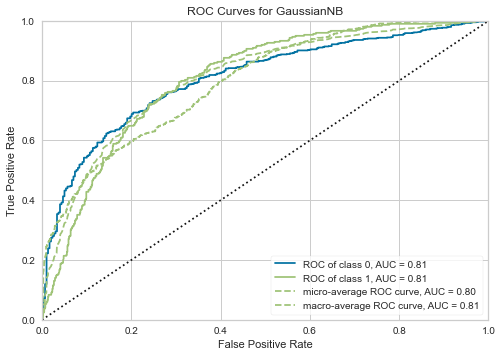

In [25]:
# AUC-ROC plot
pyc.plot_model(model_best, plot = 'auc')

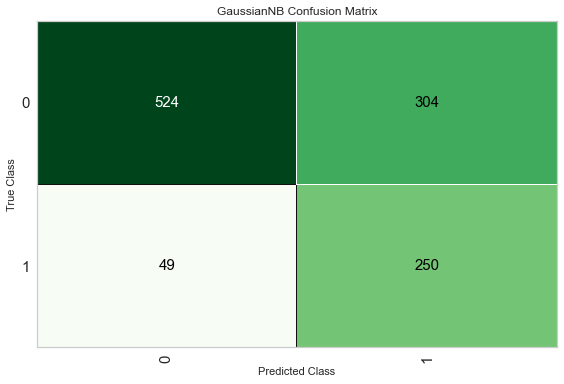

In [26]:
# confusion matrix
pyc.plot_model(model_best, plot = 'confusion_matrix')

In [27]:
# evaluate model (click on buttons)
pyc.evaluate_model(model_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<a id="" ></a>

<h1>  Model Interpretation of Tree Methods (Validation) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.interpret_model(
    estimator,
    plot           = 'summary',
    feature        = None,
    observation    = None,
    use_train_data = False,
    **kwargs,
)
```

- not supported models: logistic regression, nb
- supported models : rf, xgboost, lightgbm, catboost, dt, et

In [28]:
# pyc.interpret_model?

In [29]:
# interpret_model: SHAP
# pyc.interpret_model(model_best_lr)

# note: logistic regression is not supported
# supported: rf, xgboost, lightgbm, catboost, dt, et

In [30]:
# interpret model : Correlation
# pyc.interpret_model(model_best_lr,plot='correlation')

In [31]:
# interpret model : Reason
# pyc.interpret_model(model_best_lr,plot='reason',obervation=12)

<a id="" ></a>

<h1>  Finalize model (Fit whole train data) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.finalize_model(
    estimator,
    fit_kwargs = None,
    group      = None,
    model_only = True,
)

Docstring:
This function trains a given estimator on the entire dataset including the 
holdout set.
```

In [32]:
# pyc.finalize_model?

In [33]:
model_final = pyc.finalize_model(model_best)
print(model_final)

GaussianNB(priors=None, var_smoothing=3.882343979763128e-08)


<a id="" ></a>

<h1>  Model Evaluation on Test Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [34]:
df_preds = pyc.predict_model(model_final,df_test)
df_preds.iloc[-5:,-5:]

,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat,Label,Score
1404,16.585135,0,0,1,0.9924
1405,-19.764865,3,0,0,0.9986
1406,6.085135,1,0,1,1.0000
1407,30.735135,1,0,1,0.9969
1408,-2.787658,1,0,1,0.9936


In [35]:
ytest = df_preds[target_name].to_numpy().ravel()
yprobs = df_preds['Score'].to_numpy().ravel()
ypreds = df_preds['Label'].to_numpy().ravel()

yprobs2d = np.c_[1-yprobs,yprobs]

In [36]:
pred_name = 'pycaret_nb'
path_pred = f'../predictions/{pred_name}.csv'

df_preds_out = pd.DataFrame({'customerID': ser_test_ids})
df_preds_out[f'ypreds_{pred_name}'] = ypreds
df_preds_out[f'yprobs_{pred_name}'] = yprobs2d[:,1]

df_preds_out.to_csv(path_pred,index=False)

df_preds_out.head()

,customerID,ypreds_pycaret_nb,yprobs_pycaret_nb
0,1794-HBQTJ,1,0.9967
1,0356-OBMAC,0,1.0000
2,4077-CROMM,1,0.7255
3,5442-PPTJY,0,1.0000
4,2333-KWEWW,0,1.0000


              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1035
           1       0.46      0.83      0.59       374

    accuracy                           0.70      1409
   macro avg       0.69      0.74      0.68      1409
weighted avg       0.79      0.70      0.71      1409

[[670 365]
 [ 62 312]]


,Accuracy,Precision,Recall,F1-score,AUC
pycaret_nb,0.6969,0.4609,0.8342,0.5937,0.7408


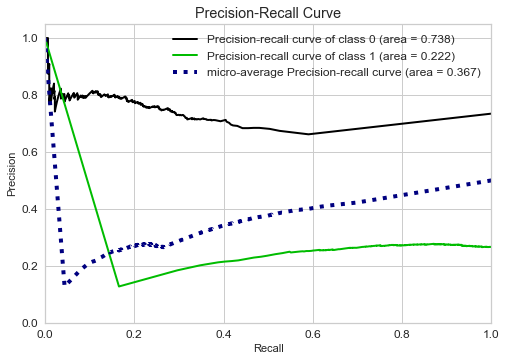

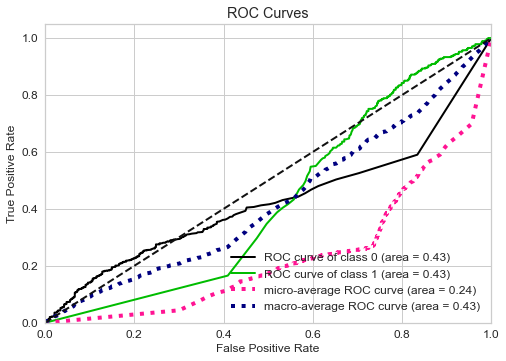

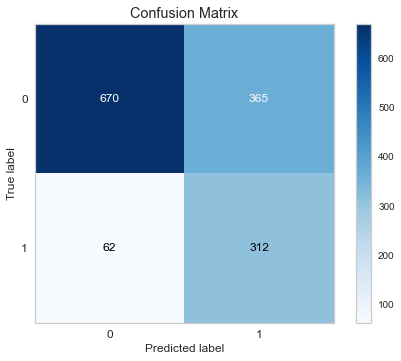

In [37]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
    skpmetrics.plot_roc_curve(ytest,yprobs2d) # equal focus on both groups
    skpmetrics.plot_confusion_matrix(ytest,ypreds)

model_eval_bin('pycaret_nb',ytest,ypreds,yprobs2d,show_plots=True)

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [38]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 1 min 5 secs
